In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# Ödev 3
Bu ödevde elimizde fraud(dolandırıcılık) tespiti yapılması istenen bir veri seti bulunmaktadır. Uçtan uca bir makine öğrenmesi projesi olarak tasarlanırken sırasıyla aşağıdaki sorulara cevap verilecektir.

1-) One hot encoding modelin görmediği veriye nasıl uygulanır?

2-) Labelencoding'de ilgili kolon için ölçeklendirme nasıl yapılır? 
(Verinin doğru etkisiyle sayısal olarak dönüştürülmesi)

3-) Imbalance datasette train test split yaparken neleri göz önünde bulundurmalıyız?

4-) Validation dataseti (modelin görmediği) nasıl oluşturulur ve nasıl predict etmeye hazır hale getirilir?

5-) predict_proba metoduyla oran nasıl hesaplanır ve treshold nasıl değiştirilir?

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("auto_insurance_csv.csv")
df

,Unnamed: 0,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,0,328,48.0,521585,2014-10-17,OH,250/500,1000,1406.91,0.0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,1,228,42.0,342868,2006-06-27,IN,250/500,2000,1197.22,5000000.0,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,2,134,29.0,687698,2000-09-06,OH,NaN,2000,1413.14,5000000.0,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NaN,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,3,256,41.0,227811,1990-05-25,IL,NaN,2000,1415.74,6000000.0,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,4,228,44.0,367455,2014-06-06,IL,NaN,1000,1583.91,6000000.0,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NaN,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,3,38.0,941851,1991-07-16,OH,NaN,1000,1310.80,0.0,431289,FEMALE,Masters,craft-repair,paintball,unmarried,0,0,2015-02-22,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,6045 Andromedia St,20,1,YES,0,1,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,996,285,41.0,186934,2014-01-05,IL,NaN,1000,1436.79,NaN,608177,FEMALE,PhD,prof-specialty,sleeping,wife,70900,0,2015-01-24,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,3092 Texas Drive,23,1,YES,2,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,997,130,NaN,918516,2003-02-17,OH,250/500,500,1383.49,3000000.0,442797,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,35100,0,2015-01-23,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,7629 5th St,4,3,?,2,3,NaN,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,998,458,62.0,533940,2011-11-18,IL,500/1000,2000,1356.92,NaN,441714,MALE,Associate,handlers-cleaners,base-jumping,wife,0,0,2015-02-26,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,6128 Elm Lane,2,1,?,0,1,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


## Null Değerlerin Tespiti ve Bu Değerlerin Doldurulması

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1000 non-null   int64  
 1   months_as_customer           1000 non-null   int64  
 2   age                          865 non-null    float64
 3   policy_number                1000 non-null   int64  
 4   policy_bind_date             1000 non-null   object 
 5   policy_state                 1000 non-null   object 
 6   policy_csl                   127 non-null    object 
 7   policy_deductable            1000 non-null   int64  
 8   policy_annual_premium        1000 non-null   float64
 9   umbrella_limit               802 non-null    float64
 10  insured_zip                  1000 non-null   int64  
 11  insured_sex                  1000 non-null   object 
 12  insured_education_level      1000 non-null   object 
 13  insured_occupation 

Yukarıda görüldüğü üzere kolonlarda null değerler bulunmaktadır. Bu değerler paylaşılan Auto Insurence Fraud notebook'undaki modellerle karşılaştırılma yapılması adına aynı değerlerle doldurulacaktır.

In [4]:
#umbrella_limit kolonundaki null değerler 9999 sayısıyla doldurulmaktadır ve 
#sayısal değerler other isimli bir değişkende toplanmaktadır
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
    if (umb != '0.0') & (umb != '9999'):
        df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')

#police_report_available kolonundaki null değerler MISSING olarak değiştirilmektedir.
df['police_report_available'] = df.police_report_available.fillna("MISSING")

#policy_csl kolonundaki null değerler MISSING olarak değiştirilmektedir.
df['policy_csl'] = df.policy_csl.fillna("MISSING")

#policy_bind_date ve incident_date kolonundaki değerler tarih değerlerine dönüştürülür ve 
#birbirlerinden çıkarılarak claim_day_of_policy adında bir kolon oluşturulur.
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days

#location_check adlı bir kolon oluşturulur. Bu kolon poliçenin hazırlandığı yer ve kazanın yaşandığı yerin birbiriyle 
#aynı olup olmadığını kontrol eden bool bir kolon oluşturur.
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)

#Buradan itibaren gruplamalar yapılmıştır.

#age kolonunun null değerleri 9999 değeriyle doldurulur ve age_group adında yeni bir kolon oluşturularak
#yaş değerleri 5'er yıllık gruplara bölünmüştür.
df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]
df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

#months_as_customer kolonu, months_as_customer_groups adında kişinin kaç aydır müşteri olduğunun
#gruplandığı bir kolona dönüştürülmüştür.
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']
df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

#policy_annual_premium kolonu, policy_annual_premium_groups adında poliçenin kalitesinin gruplandığı bir kolona dönüşmüştür
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']
df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']
df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

#fraud_reported kolonuna elle bir label encoding işlemi uygulanmıştır.
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)

## Visualization

Burada değerlerini gruplayarak yeniden oluşturduğumuz kolonların ***fraud_reported*** kolonuyla ilişkisi incelenmektedir.

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

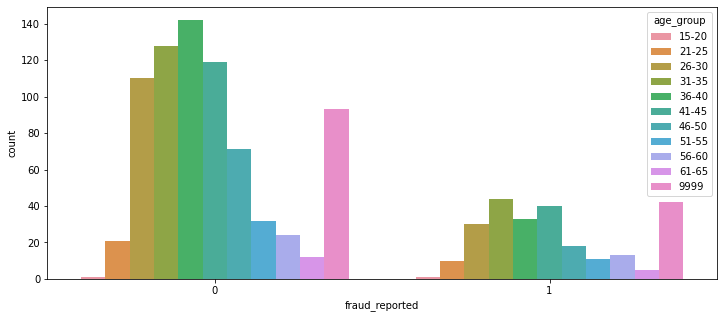

In [5]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['fraud_reported'],hue='age_group',data=df)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

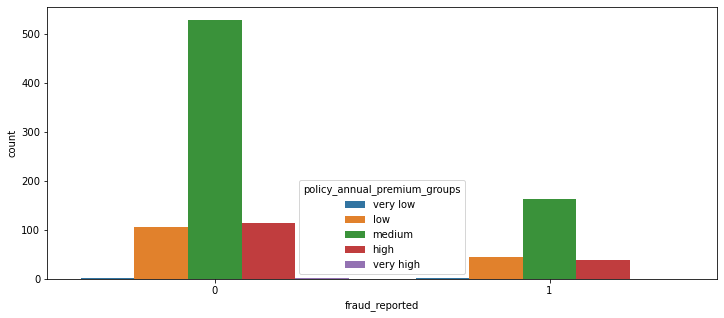

In [6]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['fraud_reported'],hue='policy_annual_premium_groups',data=df)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

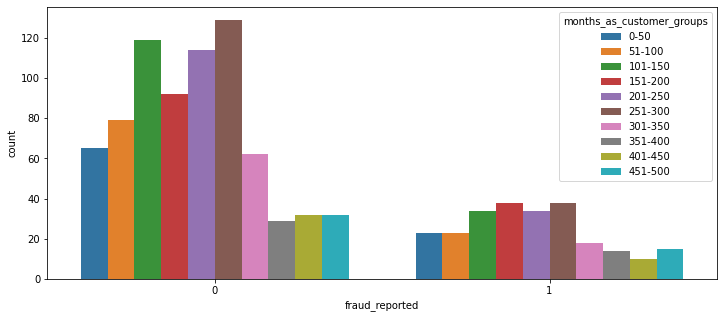

In [7]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['fraud_reported'],hue='months_as_customer_groups',data=df)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

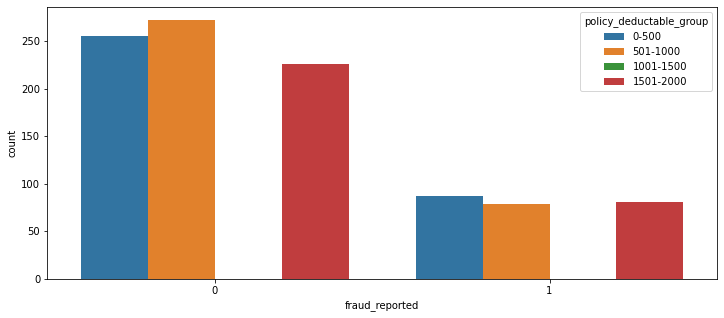

In [8]:
plt.figure(figsize=(12,5))
sns.countplot(x=df['fraud_reported'],hue='policy_deductable_group',data=df)

- Yaş gruplarına bakıldığında gençlerin fraud sayısının yüksek olmasına rağmen 46 yaş ve üzeri kişilerin beklenenden daha çok dolandırıcılığa karıştığı görülmektedir.
- Sigorta paket bilgisine bakıldığında orta seviye paket alanların daha çok dolandırıcılık yaptığı görülmektedir. Aynı grafikteki bilgilerden çoğunluğun orta seviye paketi daha çok tercih ettiği de ortaya çıkmaktadır.
- Müşteri olarak geçirilen ay süresinde 8 ve 25 yıl boyunca müşteri olanlarda dolandırıcılık oranı daha fazladır. Bunun sebebi de yine bu süre aralığında müşteri olan insanların sayısının çokluğudur.
- Insurance deductible, sigorta yaptırmadan önce alınan ücret anlamına gelmektedir. Bu ücret ne kadar yüksek olursa s,gorta şirketinin bir kaza sonrasında ödediği pay o kadar fazla olur. Bu grafikte bu ücreti alt sınırdan ödeyen grup daha çok dolandırıcılığa karışmıştır.

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Veriler doldurulduktan sonra yazdırılan heatmap'te multicollinearity problemi görülmektedir.

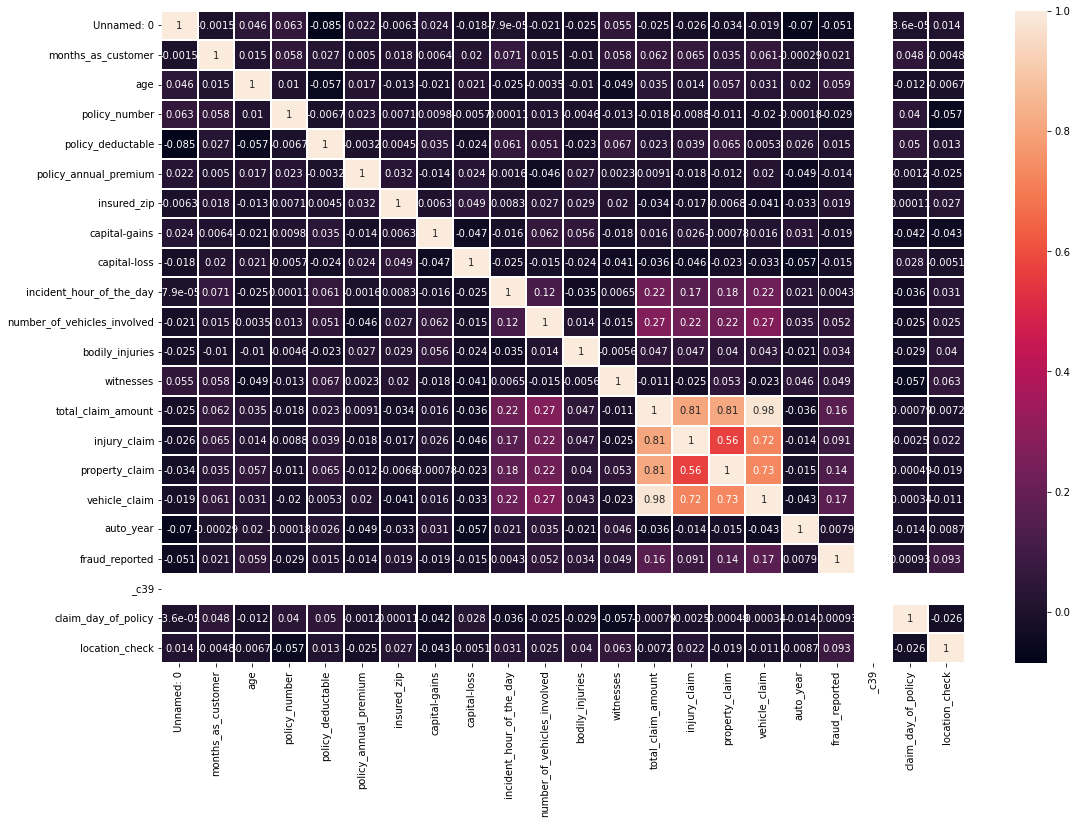

In [9]:
plt.figure(figsize = (18, 12))

corr = df.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.show()

## Multicollinearity

Multicollinearity kısaca bir değişkeni tahmin eden en az iki değişken arasında çok yüksek ilişkinin olması durumudur. Aralarındaki ilişki çok yüksek olan iki değişken kısmen birbirinin çok benzeri olacağından ikisinden birisinin atılması uygun olacaktır.

In [10]:
Image(url= "images/multicollinearity.png", width=600, height=600)

Bunun sayısal olarak tespiti için Variance Inflation Factor(varyans artış faktörü) hesaplanması yapılmalıdır.

## Variance Inflation Factor(VIF)

VIF, üzerinde tahmin yapılacak bir değişkenin varyansının ***collinearity*** nedeniyle ne kadar arttığının ölçüsünü veren bir endekstir. 
- Not: Collinearity, iki değişken arasındaki lineer ilişkiyi tanımlar. Multicollinearity'nin aksine çoklu bağlantıyı göstermez.

VIF hesaplandıktan sonra çıkan değerler şu şekilde incelenir:
- VIF=1 ise multicollinearity yok.

- VIF=<5 ise düşük multicollinearity veya kısmi korelasyon

- VIF=>5 ise yüksek multicollinearity veya yüksek korelasyon

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#nümerik kolonların seçilmesi
num_cols0 = df[list(df.select_dtypes(include=['int64']))]

#nümerik kolonların VIF değerlerini göstermek için farklı bir dataFrame oluşturulması ve değerlerin yazdırılması
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(num_cols0.values, i) for i in range(num_cols0.shape[1])]
vif_info['Column'] = num_cols0.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
11,inf,total_claim_amount
14,inf,vehicle_claim
13,inf,property_claim
12,inf,injury_claim
15,76.553317,auto_year
4,50.262967,insured_zip
2,5.576955,policy_number
8,4.666654,number_of_vehicles_involved
3,4.598610,policy_deductable
1,4.226370,months_as_customer


Bu sonuçlara göre 4 kolonda ***infinite(sonsuz)*** değerler vardır. Buna **Perfect Correlation** denir. Sebebi bu 4 kolonun birbiriyle fazlaca ilişkili olmasıdır. Bu sorunu, kolonları atarak çözebiliriz. Öncelikle vehicle_claim, property_claim ve property_claim kolonlarının total_claim_amount kolonuna eşit oduğunu gösterelim

In [12]:
df["Total"] = df["vehicle_claim"] + df["property_claim"] + df["injury_claim"]
df.Total.sum()

52761940

In [13]:
df.total_claim_amount.sum()

52761940

Burada görüldüğü üzere bu 3 kolonun atılarak sadece total_claim_amount kolonunun bırakılması infinite problemini çözecektir. Gereksiz görülen diğer kolonlar da atılacaktır.

In [14]:
#multicollinearity düzenlemesi için atıldı
df = df.drop(['vehicle_claim', 'property_claim', 'injury_claim', 'Total', 'auto_year', 'insured_zip'], axis = 1)

#claim_day_of_policy kolonu oluşturulduğu için atıldı
df = df.drop(['policy_bind_date','incident_date'],axis=1)

#sadece null değerler var
df = df.drop(['_c39','Unnamed: 0'], axis = 1)

#bu kolonlarda gruplama yapıldığı için atıldılar.
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)

#policy_number kolonu modeli eğitirken önemsiz olduğu için atıldı
df = df.drop(['policy_number'], axis = 1)

- VIF değerlerini tekrar yazdırdığımızda total_claim_amount kolonundaki infinite sorununun düzelmiş olduğunu ve yüksek VIF değerli kolonların atıldığını görürüz.
- Null değerlerin temizlendiğini de tekrar kontrol etmekteyiz.

In [15]:
#nümerik kolonların VIF değerlerini göstermek için farklı bir dataFrame oluşturulması ve değerlerin yazdırılması
num_cols0 = df[list(df.select_dtypes(include=['int64']))]
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(num_cols0.values, i) for i in range(num_cols0.shape[1])]
vif_info['Column'] = num_cols0.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
6,5.145819,total_claim_amount
3,4.221476,number_of_vehicles_involved
2,3.619873,incident_hour_of_the_day
7,3.135658,claim_day_of_policy
5,2.445818,witnesses
4,2.278841,bodily_injuries
1,1.851825,capital-loss
0,1.758249,capital-gains


In [16]:
df.isnull().sum()

policy_state                    0
policy_csl                      0
umbrella_limit                  0
insured_sex                     0
insured_education_level         0
insured_occupation              0
insured_hobbies                 0
insured_relationship            0
capital-gains                   0
capital-loss                    0
incident_type                   0
collision_type                  0
incident_severity               0
authorities_contacted           0
incident_state                  0
incident_city                   0
incident_location               0
incident_hour_of_the_day        0
number_of_vehicles_involved     0
property_damage                 0
bodily_injuries                 0
witnesses                       0
police_report_available         0
total_claim_amount              0
auto_make                       0
auto_model                      0
fraud_reported                  0
claim_day_of_policy             0
location_check                  0
age_group     

# Soru 1

**One hot encoding modelin görmediği veriye nasıl uygulanır?**

Verileri encoding'e hazırlamak için önce ***object*** veri tipindeki verileri ***category*** haline çevirmek gerekir. Bunun birkaç sebebi var:
- Category veri tipi bellek optimizasyonuna çok daha uygun. Bu da modeli eğitirken zaman kazandırmaktadır.
- Bir değişkenin sözcük sırası mantıksal sıra ile aynı değildir. Kategoriye dönüştürerek ve kategoriler üzerinde bir sıra belirleyerek, sözlük sırası yerine mantıksal sırayı kullanacaktır.

In [17]:
#Seçilen kolonların category veri tipine dönüştürülmesi
for col in [ 'policy_state','umbrella_limit', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship',
            'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location',
             'property_damage',  'police_report_available', 'auto_make', 'auto_model', 'fraud_reported']:
    df[col] = df[col].astype('category')

In [18]:
#Kolon veri tipleri dönüştürüldü
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   policy_state                  1000 non-null   category
 1   policy_csl                    1000 non-null   category
 2   umbrella_limit                1000 non-null   category
 3   insured_sex                   1000 non-null   category
 4   insured_education_level       1000 non-null   category
 5   insured_occupation            1000 non-null   category
 6   insured_hobbies               1000 non-null   category
 7   insured_relationship          1000 non-null   category
 8   capital-gains                 1000 non-null   int64   
 9   capital-loss                  1000 non-null   int64   
 10  incident_type                 1000 non-null   category
 11  collision_type                1000 non-null   category
 12  incident_severity             1000 non-null   cat

Kategorik veriler üzerinde one hot encoding uygulandığında train ve test veri setlerindeki verilerde sayısal anlamda bir düzensizlik ortaya çıkmaktadır. Bunun yanında tekrar multicollinearity'e de sebep olabilir. Bu durumları aşmak için ***Pipeline*** kullanılacaktır.

## Pipeline

- Pipeline, aslında bir veri bilimi kavramı değil, çok temel bir bilgisayar mimarisi ve sistem programlama kavramıdır. Birden fazla işin paralel olarak aynı anda yürütülmesine olanak sağlar. 
- Burada iş olarak tanımladığımız kavram sistem programlama terimiyle ***proses(task)*** olarak adlandırılır ve aslında CPU'nun mümkün olduğu kadar çok kullanılabilmesi hedeflenir.
- Proseslerin özelliklerine bağlı olarak kullanılan birbirinden farklı CPU paylaşım yöntemlerine iş sıralama algoritmaları denir.
- ***Aşağıdaki resimde t zamanda 5 farklı prosesi paralel olarak işleyen bir pipeline yapısı görülmektedir***

In [19]:
Image(url= "images/pipeline.jpg", width=600, height=600)

- Scikit Learn kütüphanesi de bu yapıyı örnek alarak bir Pipeline yapısı oluşturmuştur. İçerisine ***column_transformer*** adında bir nesne verilerek yapılması istenen işlemlerin(StandardScaler, OneHotEncoder, LabelEncoder) birbirine paralel olarak ilerleyerek çalışmasını sağlar. Aynı zamanda oluşabilecek hataların da önüne geçmiş olur.
- **Pipeline yapısı 2. sorunun cevaplanmasıyla birlikte gösterilecektir.**

# Soru 2

**Label Encoding'de ilgili kolon için ölçeklendirme nasıl yapılır? (Verinin doğru etkisiyle sayısal olarak dönüştürülmesi)**

- Label Encoding, model eğitme işlemi numerik veriler üzerinden gerçekleştiği için kategorik verileri 0'dan ***n*** değerine kadar numaralandıran bir encoding işlemidir. 
- Bu encoding türünün en büyük problemi her kategorik verinin bir sıralaması veya ağırlığının olmamasıdır.
- Bunun için ordinal veriler kullanılması gerekir. Elimizdeki ***policy_annual_premium_groups*** kolonunu bu işlem için kullanacağız.
- Ayrıca encoding yaparken bunu kolonda bulunan değerlerin alfabetik sıralamasına göre yapar. Bizim isteğimizse mantıksal bir düzende yeniden numaralandırma yapabilmektir.
- Bunun için ***Ordinal Encoding*** yapabilir ve değerlerimizi manuel olarak atayabiliriz.

In [20]:
#Bu kolon ordinal değerler içermekte ve veri setinde ordinal encoding'e en uygun kolondur.
df[["policy_annual_premium_groups"]]

,policy_annual_premium_groups
0,medium
1,medium
2,medium
3,medium
4,high
...,...
995,medium
996,medium
997,medium
998,medium


Bu kolonda bulunan 5 değer de gösterilmektedir. Eğer label encoding yapılsaydı ilk yazdırılan listeye 0'dan 4'e kadar sayısal değerler atanacaktı ama veri tipi kategoriğe çevrildiği için aralarındaki mantıksal ilişki aşağıdaki satırda gösterilmektedir. 

In [21]:
df.policy_annual_premium_groups.unique()

['medium', 'high', 'low', 'very high', 'very low']
Categories (5, object): ['very low' < 'low' < 'medium' < 'high' < 'very high']

Manuel olarak ordinal encoding işlemi basitçe map() fonksiyonuyla yapılmaktadır. Aynı işlem sckit learn kütüphanesinden de yapılabilir.

In [22]:
df["policy_annual_premium_groups_encoded"] = df["policy_annual_premium_groups"].map(
    {'very low':1, 'low':2, 'medium':3, 'high':4, 'very high':5})

In [23]:
#Veriler istediğimiz şekilde encode edildi
df[["policy_annual_premium_groups", "policy_annual_premium_groups_encoded"]]

,policy_annual_premium_groups,policy_annual_premium_groups_encoded
0,medium,3
1,medium,3
2,medium,3
3,medium,3
4,high,4
...,...,...
995,medium,3
996,medium,3
997,medium,3
998,medium,3


In [24]:
#kategorik verileri içeren verilerin düşürülmesi
df = df.drop(['policy_annual_premium_groups'], axis = 1)

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

İlk soruda bahsedilen pipeline yapısı artık oluşturulabilir. Öncelikle bir column_transformer nesnesi tanımlanarak StandardScaler ve OneHotEncoder işlemleri içerisine yazdırılacaktır. Bunun için önce kategorik ve numerik kolonların yazdırılması gerekir.

In [25]:
#kategorik kolonların yazdırılması. burada policy_annual_premium_groups_encoded kolonu gözükmekte ama 
#zaten ordinal encoding yapıldığı için column_transformer'da işleme katılmayacaktır.
cat_cols = df.select_dtypes(include=['category'])
cat_cols.columns

Index(['policy_state', 'policy_csl', 'umbrella_limit', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'property_damage',
       'police_report_available', 'auto_make', 'auto_model', 'fraud_reported',
       'age_group', 'months_as_customer_groups', 'policy_deductable_group',
       'policy_annual_premium_groups_encoded'],
      dtype='object')

In [26]:
#numerik kolonların yazdırılması.
num_cols = df.select_dtypes(include=['int64'])
num_cols.columns

Index(['capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'claim_day_of_policy'],
      dtype='object')

In [27]:
#column_transformer nesnesinin oluşturulması. burada OneHotEncoder içerisindeki handle_unknown parametresi
#verilerin tekrar ederek shape error vermesi engellenecektir.
column_trans = make_column_transformer(
               (StandardScaler(), ['capital-gains', 'capital-loss',
                                   'incident_hour_of_the_day', 'number_of_vehicles_involved',
                                   'bodily_injuries', 'witnesses', 'total_claim_amount',
                                   'claim_day_of_policy'
                                   ]),
               (OneHotEncoder(handle_unknown="ignore"), ['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
                                   'insured_occupation', 'insured_hobbies', 'insured_relationship',
                                   'incident_type', 'collision_type', 'incident_severity',
                                   'authorities_contacted', 'incident_state', 'incident_city',
                                   'incident_location', 'property_damage', 'police_report_available',
                                   'auto_make', 'auto_model', 'age_group',
                                   'months_as_customer_groups',
                                   'policy_deductable_group', 'umbrella_limit']),
               remainder="passthrough")

Artık model eğitme aşamasına geçilebilir. İlk eğitim aşaması için Mantıksal Regresyon seçilmiştir.

In [28]:
X = df.drop("fraud_reported", axis="columns")
y = df.fraud_reported

Column_trans nesnesi fit_transform edildiğinde (1000,1184) şeklinde ve içerisinde 31009 değer olan bir matris tutulduğu bilgisini yazdırdı.

In [29]:
column_trans.fit_transform(X, y)

<1000x1184 sparse matrix of type '<class 'numpy.float64'>'
	with 31009 stored elements in Compressed Sparse Row format>

In [30]:
#train ve test veri setlerinin ayrılması
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [31]:
#Mantıksal regresyon modelinin çağırılması
log_reg = LogisticRegression(random_state=42)

In [32]:
#pipeline yapısı kurulumu. bu şekilde column_trans içerisindeki çok sayıda veri hızlı bir şekilde eğitilecektir.
pipe_log_reg = make_pipeline(column_trans, log_reg)

In [33]:
#artık model yerine pipe değişkenini verebiliriz
pipe_log_reg.fit(X_train, y_train)
preds = pipe_log_reg.predict(X_test)

#Mantıksal regresyon skorunun yazdırılması
score = pipe_log_reg.score(X_test, y_test)
print(score*100)

76.8


Son bilgilerin de yazdırılmasıyla ilk model eğitilmiş oldu

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       183
           1       0.60      0.42      0.49        67

    accuracy                           0.77       250
   macro avg       0.70      0.66      0.67       250
weighted avg       0.75      0.77      0.75       250



<AxesSubplot:>

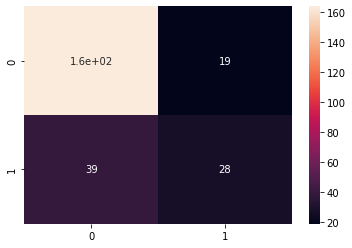

In [34]:
#evaluation metriklerinin yazdırılması ve heatmap
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Soru 3

**Imbalance datasette train test split yaparken neleri göz önünde bulundurmalıyız?**

Öncelikle incelemek istenilen veride dengesizlik olup olmadığı kontrol edilmelidir.

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

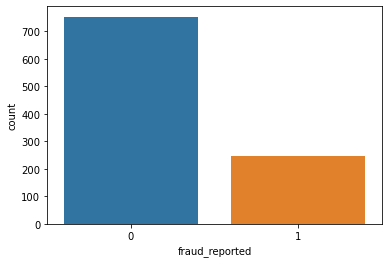

In [35]:
sns.countplot(df['fraud_reported'])

Imbalance(dengesiz) veriler, ***dolandırıcılık tespiti(fraud detection), kanserli hücre tahmini veya ağlara saldırı tespiti(intrusion detection in networks)*** veri setlerinde oldukça yaygındırlar. Ama çoğu makine öğrenmesi algoritması imbalance veri setlerinde doğru çalışmaz. Bu yüzden bir düzenleme işlemi yapılması gerekmektedir. Imbalance veri setlerini düzenlemek için birçok yöntem bulunmaktadır:
- **Under sampling majority class**: Çoğunluk sınıfının değerlerinin daha azının kullanılmasıdır. Elimizdeki veri seti için 0 kümesi değerlerini(fraud tespit edilmeyen), 1 kümesi değerleri(fraud tespit edilmiş) ile eşitlemek anlamına gelir. Ama çok fazla veri kaybı olacağı için önerilmez.
- **Over sampling minorty class by duplication**: Minör kümenin verilerini majör kümenin verileri sayısına eşit olacak şekilde kopyalamak anlamına gelmektedir.
- **Over sampling minorty class using SMOTE**: K-Nearest Neighbors algoritması kullanarak over-sampling işlemi yapmaktır. Burada aynı verilerin kopyalanması yerine komşulukları alınarak minör küme verileri doldurulur.
- **Ensemble Method**: Kümeleri bölünebilecek kadar eşit parçaya bölüp(örneğin elimizdeki veri setinde majör kümeyi 3 kere bölerek minör kümeye eşitleyebiliriz) modeller eğiterek bu modellerin en iyisi seçilir.


## Undersampling
Öncelikle undersampling denenecektir. Bunun için ***imblearn*** kütüphanesinden fonksiyonlar çağırılacak ve sonuçların nasıl değşitiği incelenecektir. 

In [36]:
#undersample yapmak için ayırdığımız X_train ve y_train ögelerini tekrar ayırırız.
rus = RandomUnderSampler(random_state=42, replacement=True)
X_under, y_under = rus.fit_resample(X_train, y_train)

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size = 0.3, random_state = 42)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

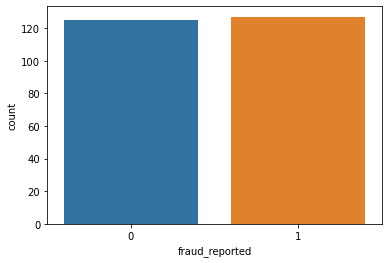

In [37]:
#kontrol sonucu majör ve minör kümelerin düşük bir değerde eşitlendiği görülmektedir.
chck2 = pd.DataFrame()
chck2['fraud_reported'] = y_train_u

sns.countplot(chck2['fraud_reported'])

Karşılaştırma yapmak amacıyla tekrar mantıksal regresyon modeli eğitilmiştir.

In [38]:
#artık model yerine pipe değişkenini verebiliriz
pipe_log_reg.fit(X_train_u, y_train_u)
preds = pipe_log_reg.predict(X_test_u)

#mantıksal regresyon skorunun yazdırılması
score = pipe_log_reg.score(X_test_u, y_test_u)
print(score*100)

79.62962962962963


Modelin eğitilmesi sonucunda fraud tahmin etme oranı ve genel skoru yükselmiştir fakat modelin veri sayısı azaldığı için güvenilirlik oranı azalmıştır. Bu yüzden oversampling de denenmelidir.

              precision    recall  f1-score   support

           0       0.81      0.78      0.80        55
           1       0.78      0.81      0.80        53

    accuracy                           0.80       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.80      0.80      0.80       108



<AxesSubplot:>

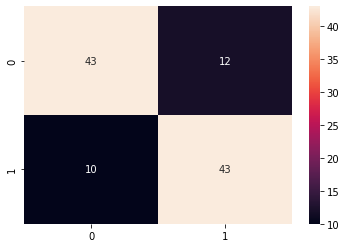

In [39]:
#evaluation metriklerinin yazdırılması ve heatmap
print(classification_report(y_test_u, preds))
cm = confusion_matrix(y_test_u, preds)
sns
sns.heatmap(cm, annot=True)

## Oversampling

Burada imblearn kütüphanesinden RandomOverSampler kullanılacaktır.

In [40]:
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [41]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, test_size = 0.3, random_state = 42)

<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

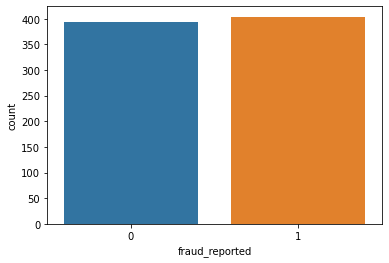

In [42]:
chck2 = pd.DataFrame()
chck2['fraud_reported'] = y_train_o

sns.countplot(chck2['fraud_reported'])

In [43]:
#artık model yerine pipe değişkenini verebiliriz
pipe_log_reg.fit(X_train_o, y_train_o)
preds = pipe_log_reg.predict(X_test_o)

#Mantıksal regresyon skorunun yazdırılması
score = pipe_log_reg.score(X_test_o, y_test_o)
print(score*100)

90.05847953216374


              precision    recall  f1-score   support

           0       0.94      0.86      0.90       176
           1       0.86      0.95      0.90       166

    accuracy                           0.90       342
   macro avg       0.90      0.90      0.90       342
weighted avg       0.90      0.90      0.90       342



<AxesSubplot:>

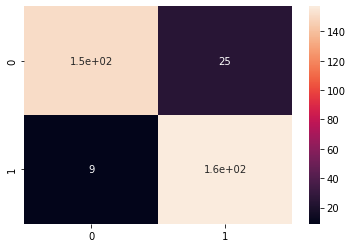

In [44]:
#evaluation metriklerinin yazdırılması ve heatmap
print(classification_report(y_test_o, preds))
cm = confusion_matrix(y_test_o, preds)
sns
sns.heatmap(cm, annot=True)

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Soru 4

**Validation dataseti (modelin görmediği) nasıl oluşturulur ve nasıl predict etmeye hazır hale getirilir?**

Validation dataseti oluşturmak dataseti train, validation ve test olarak üçe bölme işlemi gerçekleştirmek demektir. Önce train dataseti düzenlenerek validation dataseti üzerinde model seçimi yapılır. Daha sonra en uygun model test datasetinde tekrar denenir ve sonuçlar karşılaştırılır.
- Validation dataseti oluşturmak için 2 defa train_test_split çağırmak yeterlidir. Datasetleri bölme işlemi görsele göre belirlenmiştir.

In [45]:
Image(url= "images/val.png", width=600, height=600)

In [46]:
#verisetinin 3 farklı gruba bölünmesi
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.4)
relative_train_size = 0.6 / ((0.4/0.5) + 0.6)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  train_size = relative_train_size, test_size = 1-relative_train_size)

In [47]:
X_val

,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_make,auto_model,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_deductable_group,policy_annual_premium_groups_encoded
441,OH,MISSING,0.0,MALE,MD,tech-support,board-games,own-child,54600,-45500,Multi-vehicle Collision,Front Collision,Total Loss,Other,WV,Hillsdale,3925 Sky St,17,3,NO,0,3,NO,81960,Dodge,Neon,4768,False,46-50,301-350,0-500,2
218,IL,MISSING,0.0,FEMALE,MD,prof-specialty,exercise,not-in-family,24800,0,Single Vehicle Collision,Rear Collision,Total Loss,Other,WV,Hillsdale,8782 3rd St,0,1,?,2,3,?,70290,Saab,92x,6823,False,46-50,301-350,0-500,3
660,IN,MISSING,0.0,MALE,College,adm-clerical,sleeping,unmarried,42700,-64900,Multi-vehicle Collision,Front Collision,Total Loss,Police,SC,Northbrook,9734 2nd Ridge,10,3,NO,0,0,NO,62800,Jeep,Wrangler,8102,False,56-60,451-500,1501-2000,3
241,IL,100/300,0.0,FEMALE,College,adm-clerical,skydiving,other-relative,0,-74500,Single Vehicle Collision,Front Collision,Major Damage,Other,VA,Columbus,5506 Best St,20,1,YES,2,0,NO,73700,Chevrolet,Silverado,1123,False,36-40,151-200,1501-2000,4
503,IL,500/1000,other,FEMALE,PhD,handlers-cleaners,board-games,own-child,0,-42700,Single Vehicle Collision,Front Collision,Total Loss,Other,SC,Springfield,1325 1st Lane,1,1,?,1,0,MISSING,42900,Accura,TL,7073,False,9999,301-350,0-500,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,IL,MISSING,0.0,MALE,JD,protective-serv,base-jumping,own-child,0,-51100,Parked Car,?,Minor Damage,None,SC,Riverwood,3006 Lincoln Ridge,16,1,NO,2,1,MISSING,4900,Jeep,Wrangler,8542,False,26-30,51-100,1501-2000,4
741,OH,MISSING,other,MALE,College,adm-clerical,golf,not-in-family,67300,0,Single Vehicle Collision,Rear Collision,Minor Damage,Other,NC,Columbus,5058 4th Lane,4,1,NO,1,2,NO,40800,BMW,X5,3602,False,31-35,101-150,0-500,3
358,IL,MISSING,9999,MALE,College,adm-clerical,yachting,wife,0,-13200,Single Vehicle Collision,Side Collision,Major Damage,Ambulance,SC,Springfield,4907 Andromedia Drive,22,1,?,1,3,?,82800,Jeep,Grand Cherokee,4404,False,31-35,151-200,501-1000,4
107,IN,MISSING,0.0,FEMALE,High School,handlers-cleaners,camping,own-child,0,-57000,Multi-vehicle Collision,Front Collision,Major Damage,Ambulance,WV,Columbus,7428 Sky Hwy,22,2,NO,1,0,?,74200,Volkswagen,Passat,8464,False,26-30,101-150,1501-2000,3


In [48]:
y_val

441    0
218    1
660    0
241    1
503    0
      ..
711    0
741    0
358    1
107    0
188    1
Name: fraud_reported, Length: 343, dtype: category
Categories (2, int64): [0, 1]

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Yukarıda train, test ve validation olarak ayırdığımız datasetler 5 farklı modelde eğitilecektir. Train dataseti olarak 3. soruda oversample yapılmış olan ***X_train_o*** ve ***y_train_o*** kullanılacaktır. Pipeline yapısı kullanıldığı için validation dataseti her model için encode ve scale olacaktır. En yüksek skoru veren model test datasetiyle tekrar denenecektir.

## Logistic Regression

In [49]:
#artık model yerine pipe değişkenini verebiliriz
pipe_log_reg.fit(X_train_o, y_train_o)
preds = pipe_log_reg.predict(X_val)

#Mantıksal regresyon skorunun yazdırılması
score_logreg = pipe_log_reg.score(X_val, y_val)
print(score_logreg)

0.8775510204081632


              precision    recall  f1-score   support

           0       0.95      0.88      0.91       248
           1       0.73      0.87      0.80        95

    accuracy                           0.88       343
   macro avg       0.84      0.88      0.86       343
weighted avg       0.89      0.88      0.88       343



<AxesSubplot:>

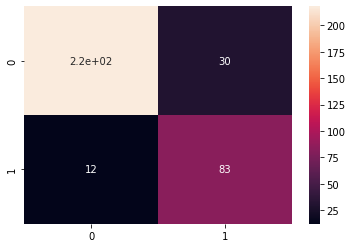

In [50]:
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

## Random Forest

In [51]:
random_forest = RandomForestClassifier(criterion= 'entropy', 
                                  max_depth= 10, 
                                  max_features= 'sqrt', 
                                  min_samples_leaf= 1, 
                                  min_samples_split= 3, 
                                  n_estimators= 140,
                                  random_state=42)

In [52]:
pipe_random_forest = make_pipeline(column_trans, random_forest)

In [53]:
pipe_random_forest.fit(X_train_o, y_train_o)
preds = pipe_random_forest.predict(X_val)

score_ranfor = pipe_random_forest.score(X_val, y_val)
print(score_ranfor)

0.8862973760932945


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       248
           1       0.75      0.89      0.81        95

    accuracy                           0.89       343
   macro avg       0.85      0.89      0.87       343
weighted avg       0.90      0.89      0.89       343



<AxesSubplot:>

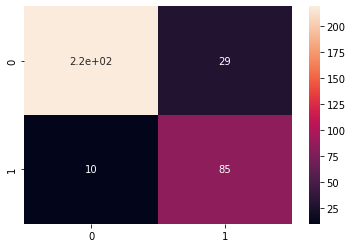

In [54]:
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

## Decision Tree

In [55]:
dtc = DecisionTreeClassifier(random_state=42)

In [56]:
pipe_dtc = make_pipeline(column_trans, dtc)

In [57]:
pipe_dtc.fit(X_train_o, y_train_o)
preds = pipe_dtc.predict(X_val)

score_dtc = pipe_dtc.score(X_val, y_val)
print(score_dtc)

0.9037900874635568


              precision    recall  f1-score   support

           0       0.95      0.92      0.93       248
           1       0.80      0.87      0.83        95

    accuracy                           0.90       343
   macro avg       0.87      0.89      0.88       343
weighted avg       0.91      0.90      0.91       343



<AxesSubplot:>

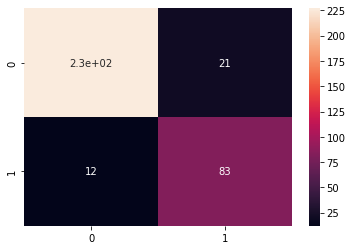

In [58]:
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

## K-Neighbours Classifier

In [59]:
knn = KNeighborsClassifier()

In [60]:
pipe_knn = make_pipeline(column_trans, knn)

In [61]:
pipe_knn.fit(X_train_o, y_train_o)
preds = pipe_knn.predict(X_val)

score_knn = pipe_knn.score(X_val, y_val)
print(score_knn)

0.717201166180758


              precision    recall  f1-score   support

           0       0.89      0.70      0.78       248
           1       0.49      0.77      0.60        95

    accuracy                           0.72       343
   macro avg       0.69      0.73      0.69       343
weighted avg       0.78      0.72      0.73       343



<AxesSubplot:>

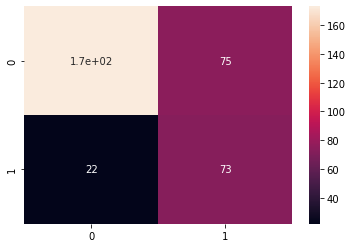

In [62]:
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

## Support Vector Machine

In [63]:
svc = SVC(random_state=42)

In [64]:
pipe_svc = make_pipeline(column_trans, svc)

In [65]:
pipe_svc.fit(X_train_o, y_train_o)
preds = pipe_svc.predict(X_val)

score_svm = pipe_svc.score(X_val, y_val)
print(score_svm)

0.8746355685131195


              precision    recall  f1-score   support

           0       0.95      0.88      0.91       248
           1       0.73      0.87      0.79        95

    accuracy                           0.87       343
   macro avg       0.84      0.87      0.85       343
weighted avg       0.89      0.87      0.88       343



<AxesSubplot:>

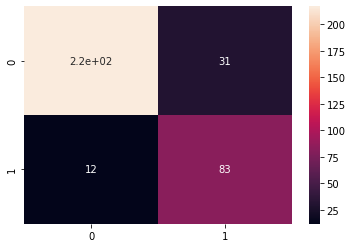

In [66]:
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

5 farklı model eğittikten sonra en iyi sonucu Decision Tree'nin verdiği görülüyor. O yüzden test veri seti üzerinde deneme yapılabilir.

In [67]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','SVM'],
    'Score' : [score_logreg, score_knn, score_dtc, score_ranfor, score_svm]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
2,Decision Tree,0.903790
3,Random Forest,0.886297
0,Logistic Regression,0.877551
4,SVM,0.874636
1,KNN,0.717201


In [68]:
preds = pipe_dtc.predict(X_test)

score_dtc = pipe_dtc.score(X_test, y_test)
print(score_dtc)

0.925


              precision    recall  f1-score   support

           0       0.97      0.94      0.95       309
           1       0.80      0.89      0.84        91

    accuracy                           0.93       400
   macro avg       0.88      0.91      0.90       400
weighted avg       0.93      0.93      0.93       400



<AxesSubplot:>

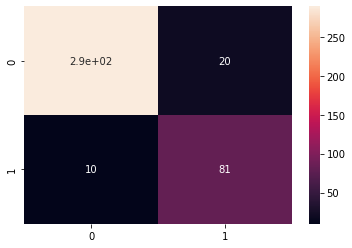

In [69]:
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

- Validation dataseti üzerinde %92 oranında başarı sağlarken test dataseti üzerinde %90 başarı sağlamıştır. 
- Burada önemli olan nokta fraud değerleri yakalayabilme oranıdır. Fraud olmadığı düşünülen ama fraud olan 10 tane veri vardır. Bu %10'luk bir hata oranını gösterir.
- Ayrıca fraud olduğu düşünülen ama fraud olmayan verilerin toplamıyla 30 veri yanlış yorumlanmıştır. Bu da kabaca her 3 işlemden 1 tanesi yanlıştır anlamına gelebilir.

# Soru 5

**predict_proba metoduyla oran nasıl hesaplanır ve treshold nasıl değiştirilir?**

Bir sınıflandırma probleminde, sınıf değerlerini doğrudan tahmin etmeye karar verebiliriz.

Alternatif olarak, bunun yerine her sınıf için olasılıkları tahmin etmek daha esnek olabilir. Bunun nedeni, tahmin edilen olasılıkların nasıl yorumlanacağına ilişkin eşiği seçme ve hatta kalibre etme yeteneği sağlamaktır.

predict() ve predict_proba() fonksiyonlarının farkı; regresyon, sınıflandırma, kümeleme gibi yöntemler kullanarak yapacağınız çalışmalarda tahmin edilen etiket bilgisini predict fonksiyonuyla elde edilebilir, sınıflandırma problemlerinde gözlemlerin sınıflara ait olma olasılıklarını elde etmek istiyorsanız predict_proba fonksiyonunun kullanılması gerekiyor.

- Olasılıkları sınıf etiketlerine yorumlamak için varsayılan eşik 0,5'tir ve bu hiperparametrenin ayarlanmasına ***threshold moving*** adı verilir.
- Threshold değeri ROC eğrisi kullanılarak belirlenebilir.

Burada örnek olarak mantıksal regresyon modeli seçilmiştir.

In [83]:
#threshold değeri rastgele seçilerek predict_proba metodunun yazdırdığı olasılık değerleriyle karşılaştırılır.
threshold = 0.25
predictions = (pipe_log_reg.predict_proba(X_test)[:, 1] >= threshold).astype(int)

In [84]:
#mantıksal regresyon için test dataseti değerleri ölçülür. yukarıda train işlemleri tamamlanmıştı
preds = pipe_log_reg.predict(X_test)
score_logreg = pipe_log_reg.score(X_test, y_test)
print(score_logreg)

0.9125


In [85]:
#threshold belirlenmeden önceki değerler ve threshold belirlendikten sonraki değerler yazdırılır.
print('Valuation for test data only:')
print(classification_report(y_test, preds))
print("----------------------------------------------------------------------")
print('Valuation for test data only  (new_threshold):')
print(classification_report(y_test, predictions))

Valuation for test data only:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       309
           1       0.76      0.90      0.82        91

    accuracy                           0.91       400
   macro avg       0.86      0.91      0.88       400
weighted avg       0.92      0.91      0.91       400

----------------------------------------------------------------------
Valuation for test data only  (new_threshold):
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       309
           1       0.62      0.95      0.75        91

    accuracy                           0.86       400
   macro avg       0.80      0.89      0.83       400
weighted avg       0.90      0.86      0.87       400



Buna göre belirlenen threshold değeri 0'ların yakalanmasında düşüş gösterse de fraud yakalama oranını hiç olmadığı kadar arttırmıştır. 